In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10429, done.
remote: Total 10429 (delta 0), reused 0 (delta 0), pack-reused 10429
Receiving objects: 100% (10429/10429), 10.62 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (7203/7203), done.


In [2]:
!which pip

/home/anish/.virtualenvs/py36_PED/bin/pip


In [7]:
!pip install -r ./yolov5/requirements.txt

     |████████████████████████████████| 60.4 MB 3.2 MB/s            
     |████████████████████████████████| 603 kB 4.7 MB/s            
     |████████████████████████████████| 63 kB 2.6 MB/s            
     |████████████████████████████████| 881.9 MB 2.7 kB/s             
     |████████████████████████████████| 23.3 MB 3.7 MB/s            
     |████████████████████████████████| 76 kB 4.0 MB/s            
     |████████████████████████████████| 5.8 MB 3.8 MB/s            
     |████████████████████████████████| 9.5 MB 3.2 MB/s            �             | 5.5 MB 3.7 MB/s eta 0:00:02
     |████████████████████████████████| 292 kB 5.1 MB/s            
     |████████████████████████████████| 138 kB 5.4 MB/s            
     |████████████████████████████████| 61 kB 4.9 MB/s            
     |████████████████████████████████| 149 kB 5.6 MB/s            
     |████████████████████████████████| 4.9 MB 3.3 MB/s            
     |████████████████████████████████| 4.1 MB 5.4 MB/s            
   

In [40]:
# Setup dataset
#!mkdir test_dataset_traffic_signs
#!cd test_dataset_traffic_signs && wget -O RoadSignDetectionDataset.zip https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/RoadSigns/RoadSignsPascalVOC.zip?region=us-east-2
#!cd test_dataset_traffic_signs && unzip RoadSignDetectionDataset.zip && rm -r __MACOSX

In [31]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
random.seed(108)

In [14]:
# Function to get the data from XML Annotation - PASCOL VAC -> Yolo_v5 format
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [19]:
print(extract_info_from_xml('./test_dataset_traffic_signs/annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [38]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, outputPath):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(outputPath, info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [39]:
# Convert XML to Yolo format
# Get the annotations
InputOutputPath='./test_dataset_traffic_signs/annotations/'
annotations = glob(InputOutputPath+'*.xml')
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict,InputOutputPath)

annotations = glob(InputOutputPath+'*.txt')

100%|██████████| 877/877 [00:00<00:00, 8407.67it/s]


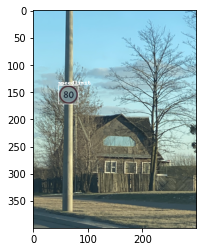

In [42]:
# Testing the annotations

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [48]:
# Setup dataset for train, val and test
# =====================================# 
# Read images and annotations

rootPath='./test_dataset_traffic_signs/'

#images = np.array(glob(rootPath+'image/*.png').sort())
#annotations = np.array(glob(rootPath+'annotations/*.xml').sort())

images = [os.path.join(f'{rootPath}/images', x) for x in os.listdir(f'{rootPath}/images')]
annotations = [os.path.join(f'{rootPath}/annotations', x) for x in os.listdir(f'{rootPath}/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [55]:
!mkdir ./test_dataset_traffic_signs/images/train 
!mkdir ./test_dataset_traffic_signs/images/val 
!mkdir ./test_dataset_traffic_signs/images/test 
!mkdir ./test_dataset_traffic_signs/annotations/train 
!mkdir ./test_dataset_traffic_signs/annotations/val 
!mkdir ./test_dataset_traffic_signs/annotations/test

In [58]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            #assert False

# Move the splits into their folders
move_files_to_folder(train_images, './test_dataset_traffic_signs/images/train')
move_files_to_folder(val_images, './test_dataset_traffic_signs/images/val/')
move_files_to_folder(test_images, './test_dataset_traffic_signs/images/test/')
move_files_to_folder(train_annotations, './test_dataset_traffic_signs/annotations/train/')
move_files_to_folder(val_annotations, './test_dataset_traffic_signs/annotations/val/')
move_files_to_folder(test_annotations, './test_dataset_traffic_signs/annotations/test/')

./test_dataset_traffic_signs//images/road260.png
./test_dataset_traffic_signs//images/road573.png
./test_dataset_traffic_signs//images/road851.png
./test_dataset_traffic_signs//images/road757.png
./test_dataset_traffic_signs//images/road412.png
./test_dataset_traffic_signs//images/road153.png
./test_dataset_traffic_signs//images/road697.png
./test_dataset_traffic_signs//images/road404.png
./test_dataset_traffic_signs//images/road627.png
./test_dataset_traffic_signs//images/road621.png
./test_dataset_traffic_signs//images/road700.png
./test_dataset_traffic_signs//images/road605.png
./test_dataset_traffic_signs//images/road73.png
./test_dataset_traffic_signs//images/road22.png
./test_dataset_traffic_signs//images/road557.png
./test_dataset_traffic_signs//images/road461.png
./test_dataset_traffic_signs//images/road219.png
./test_dataset_traffic_signs//images/road428.png
./test_dataset_traffic_signs//images/road192.png
./test_dataset_traffic_signs//images/road379.png
./test_dataset_traffic

In [60]:
!mv ./test_dataset_traffic_signs/annotations ./test_dataset_traffic_signs/labels

In [62]:
!python ./yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data traffic_sign_dataset.yaml --weights yolov5s.pt --workers 24 --name yolo_road_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=traffic_sign_dataset.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_road_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 7.57 KiB | 3.78 MiB/s, done.
From https://github.com/ultralytics/yolov5
   fb83929..a2f4a17  master     -> origin/master
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull`

In [66]:
# Testing
!python ./yolov5/detect.py --source ./test_dataset_traffic_signs/images/test/ --weights ./yolov5/runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det

detect: weights=['./yolov5/runs/train/yolo_road_det/weights/best.pt'], source=./test_dataset_traffic_signs/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_road_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-172-gfb83929 torch 1.10.1+cu102 CUDA:0 (GeForce RTX 2080 Ti, 11011MiB)

Fusing layers... 
Model Summary: 213 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/88 /media/Evo_plus_1TB/PED_for_FRs/test_dataset_traffic_signs/images/test/road100.png: 640x640 1 speedlimit, Done. (0.005s)
image 2/88 /media/Evo_plus_1TB/PED_for_FRs/test_dataset_traffic_signs/images/test/road113.png: 448x640 1 speedlimit, Done. (0.004s)
image 3/88 /media/Evo_plus_1TB/PED

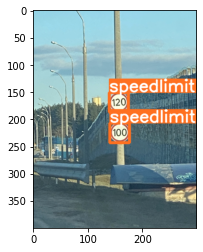

In [68]:
# Plot the inferenced images
detections_dir = "./yolov5/runs/detect/yolo_road_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [69]:
# inference example
#python ./yolov5/detect.py --source 0  # webcam
#                            file.jpg  # image 
#                            file.mp4  # video
#                            path/  # directory
#                            path/*.jpg  # glob
#                            rtsp://170.93.143.139/rtplive/470011e600ef003a004ee33696235daa  # rtsp stream
#                            rtmp://192.168.1.105/live/test  # rtmp stream
#                            http://112.50.243.8/PLTV/88888888/224/3221225900/1.m3u8  # http stream